# Detect AI vs Human generated images
In this notebook, I aim to build a convnet architecture for detecting real images from fake ones.

In [1]:
# All imports needed for this classification project
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.regularizers import l2

In [2]:
# Download latest version
data_path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", data_path)

Path to dataset files: /kaggle/input/ai-vs-human-generated-dataset


In [3]:
# Csv files with paths to the images
train = pd.read_csv(data_path+"/"+"train.csv", index_col=0)
test = pd.read_csv(data_path+"/"+"test.csv")

In [4]:
print(train.head())

                                         file_name  label
0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1


In [5]:
def create_image_fullpath(file_path, labels=None):
    """
    Creates an array with full path to the images.
    Labels array created where appropriate.
    """
    full_path = [data_path +"/"+ image_path for image_path in file_path]
    full_path = np.array(full_path)
    if labels is not None:
        labels = np.array(labels)
        return full_path, labels
    else:
        return full_path

In [6]:
# Creates full paths to images
train_full_path, labels = create_image_fullpath(train["file_name"], train["label"])
test_full_path = create_image_fullpath(test["id"])

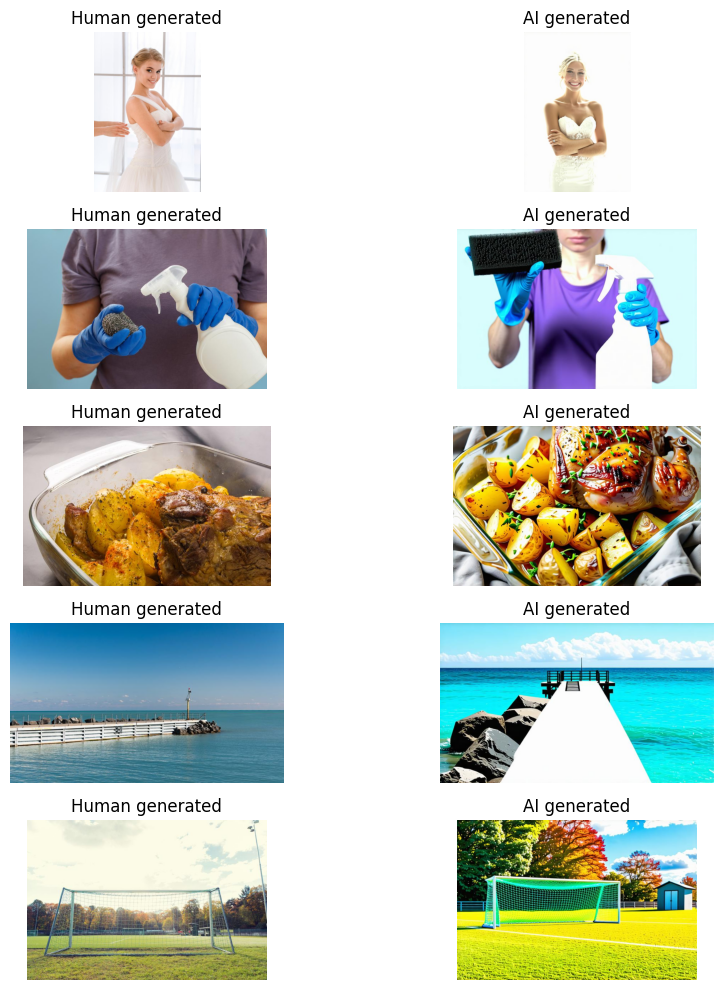

In [7]:
# Visualize the the first ten images. 
fig, ax = plt.subplots(5, 2, figsize=(10,10))

index = -1
for i in range(5):
    for j in range(2):
        im = plt.imread(train_full_path[index])
        ax[i][j].imshow(im)
        ax[i][j].axis("off")
        
        if labels[index] == 0:
            ax[i][j].set_title("Human generated")
        else:
            ax[i][j].set_title("AI generated")
            
        index -= 1

        
            
fig.tight_layout()
        


Based on the above visualizations, it's evidented the data isn't shuffled and image sizes are different.

In [8]:
# Shuffle train data
indices = np.random.permutation(len(train_full_path))
train_full_path, labels = train_full_path[indices], labels[indices]

In [9]:
# Split train into train and validation data
X_train, X_val, y_train, y_val = train_test_split(train_full_path, 
                                                  labels,
                                                  test_size=0.2,
                                                  random_state=44)

In [10]:
def load_preprocess_image(X, y=None):
    image = tf.io.read_file(X)
    image = tf.image.decode_jpeg(image, channels=3)/255
    image_resized = tf.image.resize(image, [224, 224])
    image_resized = preprocess_input(image_resized*255)

    if y is None:
        return image_resized
    else:
        return image_resized, y
    

In [11]:
# I'll convert the numpy arrays to tensorflow dataset

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [12]:
# Apply the data processing on the tf dataset
train_ds = train_ds.map(load_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(load_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Batch the dataset
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [13]:
pretrained_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
pretrained_base.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
model = keras.Sequential([
    pretrained_base,
    layers.GlobalAveragePooling2D(), 
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  
    layers.Dropout(0.5), 
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.3), 
    layers.Dense(1, activation='sigmoid')  
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    verbose=0,
)

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices(test_full_path)
test_data = test_data.map(load_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size)

In [ ]:
pred = model.predict(test_data)

In [ ]:
ar = [0 if i < 0.5 else 1 for i in pred]

In [ ]:
test["label"] = ar
test.to_csv("predictions.csv", index=False)